<a href="https://colab.research.google.com/github/koyamahr/retro-astro-jax/blob/main/hydro_shock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2-3: 衝撃波とスーパーバブル (Blast Waves)


Original Papers:
*   Sedov, L. I. (1959). "Similarity and Dimensional Methods in Mechanics.
*   "Tomisaka, K., & Ikeuchi, S. (1986). "Evolution of superbubbles in the galactic disk."


1. はじめに (Introduction)

星が最期を迎えて超新星爆発を起こすと、莫大なエネルギーが一瞬で解放されます。この衝撃波は周囲の星間ガスをなぎ払い、数百万度の高温ガスで満たされた巨大な泡 「スーパーバブル」 を作ります。この現象をシミュレーションするには、空間を固定されたマス目（グリッド）に区切り、その中を出入りするガスの量（フラックス）を計算する 「オイラー法」 が適しています。

2. JAXによる数値流体 (Finite Volume Method)

今回は、最も安定性が高く実装しやすい 「Rusanov法（Local Lax-Friedrichs法）」 を採用します。これは、音速 $c_s$ と流速 $v$ を考慮して、情報が伝わる最大速度 $\lambda_{max} = |v| + c_s$ で数値粘性を調整する手法です。

セットアップ

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

# 64bit精度推奨 (激しい値の変化があるため)
jax.config.update("jax_enable_x64", True)

物理量と状態方程式 (Physics Core)

流体は4つの変数で記述されます：密度 $\rho$、運動量 $p_x, p_y$、全エネルギー $E$。

In [2]:
# 理想気体のガンマ (単原子分子)
GAMMA = 5.0 / 3.0

@jax.jit
def get_pressure(rho, mom_x, mom_y, energy):
    """状態方程式: P = (gamma - 1) * (E - Kinetic_Energy)"""
    v_sq = (mom_x**2 + mom_y**2) / (rho**2 + 1e-10)
    P = (GAMMA - 1.0) * (energy - 0.5 * rho * v_sq)
    # 圧力は正でなければならない (数値誤差対策)
    return jnp.maximum(P, 1e-10)

@jax.jit
def get_sound_speed(rho, P):
    """音速: cs = sqrt(gamma * P / rho)"""
    return jnp.sqrt(GAMMA * P / (rho + 1e-10))

リーマンソルバー (The Flux Solver)


ここが心臓部です。隣り合うセル（LeftとRight）の間を流れる物理量（フラックス）を計算します。

In [3]:
@jax.jit
def flux_function(rho, mom_x, mom_y, energy, P, axis):
    """
    Euler方程式のフラックス F(U)
    axis=0 (X方向): [rho*u, rho*u^2+P, rho*u*v, (E+P)*u]
    axis=1 (Y方向): [rho*v, rho*v*u, rho*v^2+P, (E+P)*v]
    """
    u = mom_x / rho
    v = mom_y / rho

    if axis == 0: # X-flux
        vel_normal = u
        f0 = mom_x
        f1 = mom_x * u + P
        f2 = mom_y * u
        f3 = (energy + P) * u
    else: # Y-flux
        vel_normal = v
        f0 = mom_y
        f1 = mom_x * v
        f2 = mom_y * v + P
        f3 = (energy + P) * v

    return jnp.stack([f0, f1, f2, f3], axis=0), vel_normal

@jax.jit
def rusanov_flux(U_L, U_R, axis):
    """
    Rusanov (Local Lax-Friedrichs) Flux
    F_1/2 = 0.5 * (F_L + F_R) - 0.5 * lambda_max * (U_R - U_L)
    """
    # U = [rho, mom_x, mom_y, energy]
    rho_L, mx_L, my_L, e_L = U_L
    rho_R, mx_R, my_R, e_R = U_R

    P_L = get_pressure(rho_L, mx_L, my_L, e_L)
    P_R = get_pressure(rho_R, mx_R, my_R, e_R)

    cs_L = get_sound_speed(rho_L, P_L)
    cs_R = get_sound_speed(rho_R, P_R)

    # フラックス F_L, F_R と 流速 v_L, v_R
    F_L, vn_L = flux_function(rho_L, mx_L, my_L, e_L, P_L, axis)
    F_R, vn_R = flux_function(rho_R, mx_R, my_R, e_R, P_R, axis)

    # 最大固有値 (信号速度)
    lambda_max = jnp.maximum(jnp.abs(vn_L) + cs_L, jnp.abs(vn_R) + cs_R)

    # Rusanov Flux Formula
    # 数値拡散項: - 0.5 * lambda * (U_R - U_L)
    diff_term = 0.5 * lambda_max * (U_R - U_L)

    return 0.5 * (F_L + F_R) - diff_term

時間発展ステップ (Time Integration)

X方向とY方向のフラックスを計算し、保存量を更新します。

In [4]:
@partial(jax.jit, static_argnames=['nx', 'ny'])
def step_hydro(U, dt, dx, nx, ny):
    """1ステップの時間発展 (Euler法)"""
    # U shape: (4, nx, ny)

    # --- X方向のフラックス ---
    # 周期境界条件 (Roll)
    U_L = U
    U_R = jnp.roll(U, shift=-1, axis=1) # x+1

    # F_{i+1/2}
    F_x = rusanov_flux(U_L, U_R, axis=0)

    # フラックス差分: (F_{i+1/2} - F_{i-1/2})
    # F_{i-1/2} は F_{i+1/2} を右にずらしたもの
    dF_dx = (F_x - jnp.roll(F_x, shift=1, axis=1)) / dx

    # --- Y方向のフラックス ---
    U_D = U
    U_U = jnp.roll(U, shift=-1, axis=2) # y+1

    F_y = rusanov_flux(U_D, U_U, axis=1)

    dF_dy = (F_y - jnp.roll(F_y, shift=1, axis=2)) / dx # dx=dyとする

    # 更新
    U_new = U - dt * (dF_dx + dF_dy)

    return U_new

3. シミュレーション実行 (Sedov Blast Wave)


「セドフ解」の再現 に挑戦します。 一様な静止ガスの中に、一点だけ「超高圧」の領域を作ります。これが爆発です。

In [7]:
from functools import partial

# --- 1. ヘルパー関数 ( @jax.jit を削除 ) ---
# これにより、step_hydro 内で呼び出されたときに axis=0 という定数がそのまま伝わります

def get_pressure(rho, mom_x, mom_y, energy):
    """状態方程式"""
    v_sq = (mom_x**2 + mom_y**2) / (rho**2 + 1e-10)
    P = (GAMMA - 1.0) * (energy - 0.5 * rho * v_sq)
    return jnp.maximum(P, 1e-10)

def get_sound_speed(rho, P):
    """音速"""
    return jnp.sqrt(GAMMA * P / (rho + 1e-10))

def flux_function(rho, mom_x, mom_y, energy, P, axis):
    """フラックス計算 (ここにある if axis == 0 がエラーの原因でした)"""
    u = mom_x / rho
    v = mom_y / rho

    if axis == 0: # X-flux
        vel_normal = u
        f0 = mom_x
        f1 = mom_x * u + P
        f2 = mom_y * u
        f3 = (energy + P) * u
    else: # Y-flux
        vel_normal = v
        f0 = mom_y
        f1 = mom_x * v
        f2 = mom_y * v + P
        f3 = (energy + P) * v

    return jnp.stack([f0, f1, f2, f3], axis=0), vel_normal

def rusanov_flux(U_L, U_R, axis):
    """Rusanov Flux"""
    rho_L, mx_L, my_L, e_L = U_L
    rho_R, mx_R, my_R, e_R = U_R

    P_L = get_pressure(rho_L, mx_L, my_L, e_L)
    P_R = get_pressure(rho_R, mx_R, my_R, e_R)

    cs_L = get_sound_speed(rho_L, P_L)
    cs_R = get_sound_speed(rho_R, P_R)

    F_L, vn_L = flux_function(rho_L, mx_L, my_L, e_L, P_L, axis)
    F_R, vn_R = flux_function(rho_R, mx_R, my_R, e_R, P_R, axis)

    lambda_max = jnp.maximum(jnp.abs(vn_L) + cs_L, jnp.abs(vn_R) + cs_R)

    return 0.5 * (F_L + F_R) - 0.5 * lambda_max * (U_R - U_L)

# --- 2. メイン関数 (ここだけ @jax.jit をつける) ---

@partial(jax.jit, static_argnames=['nx', 'ny'])
def step_hydro(U, dt, dx, nx, ny):
    """1ステップの時間発展"""
    # X方向
    U_L = U
    U_R = jnp.roll(U, shift=-1, axis=1)
    F_x = rusanov_flux(U_L, U_R, axis=0) # ここで axis=0 (定数) を渡す
    dF_dx = (F_x - jnp.roll(F_x, shift=1, axis=1)) / dx

    # Y方向
    U_D = U
    U_U = jnp.roll(U, shift=-1, axis=2)
    F_y = rusanov_flux(U_D, U_U, axis=1) # ここで axis=1 (定数) を渡す
    dF_dy = (F_y - jnp.roll(F_y, shift=1, axis=2)) / dx

    # 更新
    U_new = U - dt * (dF_dx + dF_dy)
    return U_new

In [10]:
# --- パラメータ ---
nx, ny = 200, 200
dx = 1.0
CFL = 0.4

# --- 初期条件 (Sedov Setup) ---
# 必ずここから再実行してリセットしてください
rho = jnp.ones((nx, ny)) * 1.0
mom_x = jnp.zeros((nx, ny))
mom_y = jnp.zeros((nx, ny))
P_base = 1e-4

energy = jnp.ones((nx, ny)) * (P_base / (GAMMA - 1.0))
U = jnp.stack([rho, mom_x, mom_y, energy], axis=0)

# 爆発注入
center_x, center_y = nx//2, ny//2
radius = 3
Y, X = jnp.ogrid[:nx, :ny]
dist = jnp.sqrt((X - center_x)**2 + (Y - center_y)**2)

blast_energy = 1000.0
mask = dist < radius
U = U.at[3, mask].set(blast_energy)

print("💥 Explosion Initialized (Reset)!")

# --- 実行ループ ---
history = []
time = 0.0
U_curr = U

# 変更点: ステップ数を 800 -> 200 に減らす
steps = 200
print("Simulating Shockwave...")

for i in range(steps):
    rho_c, mx_c, my_c, e_c = U_curr
    P_c = get_pressure(rho_c, mx_c, my_c, e_c)
    cs_c = get_sound_speed(rho_c, P_c)

    v_c = jnp.sqrt((mx_c/(rho_c+1e-10))**2 + (my_c/(rho_c+1e-10))**2)
    max_wave_speed = jnp.max(v_c + cs_c)

    dt = CFL * dx / (max_wave_speed + 1e-10)

    U_curr = step_hydro(U_curr, dt, dx, nx, ny)
    time += dt

    if i % 10 == 0:
        history.append((U_curr, time))

print(f"Done. Final Time: {time:.2f}")

💥 Explosion Initialized (Reset)!
Simulating Shockwave...
Done. Final Time: 11.52


4. 可視化 (Visualization)


密度と圧力の断面図を見てみましょう。綺麗な「球殻（シェル）」ができているはずです。

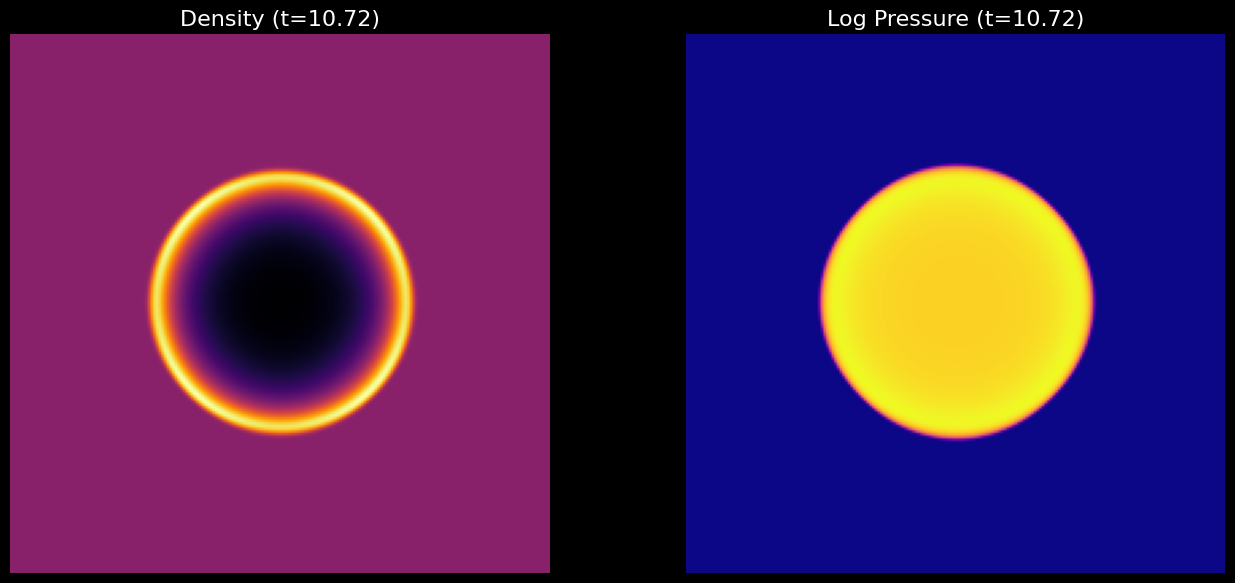

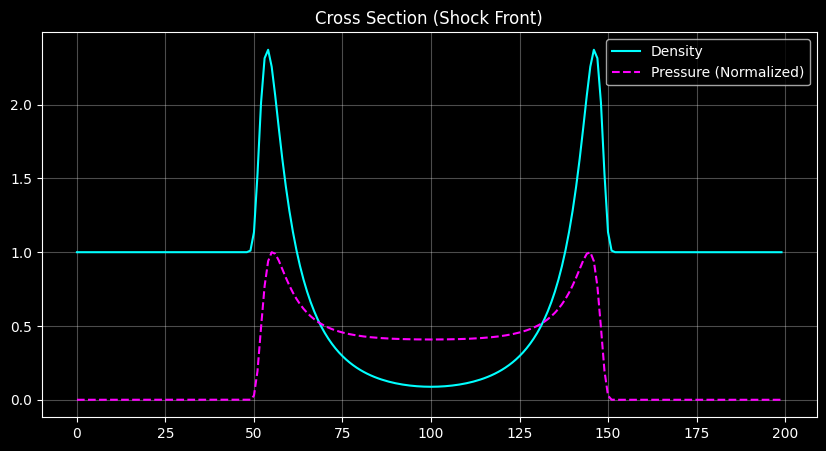

In [11]:
# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.patch.set_facecolor('black')

# 最終ステップのデータ
U_final, t_final = history[-1]
rho_final = U_final[0]
P_final = get_pressure(U_final[0], U_final[1], U_final[2], U_final[3])

# 1. 密度分布 (Density)
im1 = axes[0].imshow(rho_final.T, cmap='inferno', origin='lower', extent=[0, nx, 0, ny])
axes[0].set_title(f"Density (t={t_final:.2f})", color='white', fontsize=16)
axes[0].axis('off')

# 2. 圧力分布 (Pressure) - 対数スケールで見やすく
im2 = axes[1].imshow(jnp.log10(P_final.T), cmap='plasma', origin='lower', extent=[0, nx, 0, ny])
axes[1].set_title(f"Log Pressure (t={t_final:.2f})", color='white', fontsize=16)
axes[1].axis('off')

# 3. 1次元プロファイル (断面図)
plt.figure(figsize=(10, 5))
plt.style.use('dark_background')
mid = ny // 2
plt.plot(rho_final[:, mid], label='Density', color='cyan')
plt.plot(P_final[:, mid] / jnp.max(P_final[:, mid]), label='Pressure (Normalized)', color='magenta', linestyle='--')
plt.title("Cross Section (Shock Front)")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

結果の見方

Density (左図): 中央が空っぽで、外側に薄い「壁」があるドーナツ型が見えますか？これが 衝撃波面（Shock Front） です。セドフ解の特徴である「質量が外殻に掃き集められる」様子が再現されています。

Pressure (右図): 内側は高温・高圧のガスで満たされています。これが 「ホットバブル」 です。

Cross Section (下図): 密度が急激に立ち上がる「垂直な壁」が見えるはずです。グリッド法ならではの鋭さです。

これができたら、JAXで 「圧縮性流体力学ソルバー」 を書き上げたことになります！ 富阪・池内 (1986) は、この泡が銀河円盤の密度成層（上にいくほど空気が薄い）の中を突き破り、「チムニー（煙突）」 となってガスを噴き上げる様子を描きました。

このコードの密度分布 rho を rho = jnp.exp(-z / H) のように勾配をつけるだけで、その現象も再現できます。